# **VPG with Exploration - Grid Search**

# Import Libraries

In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
from enum import Enum

import gym
from gym import spaces
import time

from PyQt5.QtWidgets import (QApplication, QMainWindow, QWidget, QVBoxLayout, QLabel, QFrame)
from PyQt5.QtCore import Qt
from PyQt5.QtGui import QPainter, QColor, QFont, QBrush, QPen, QIcon

import torch
from torch import nn
import tensorflow as tf
import torch.optim as optim
import torch.nn.functional as F
from tensorflow.keras import layers, optimizers, losses

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
from treasure_env import *
from VanillaPolicyGradient import *

# Saving and Loading

* Model Saving

In [ ]:
def save_model(agent, file_path, extra_logs=None, hyperparams=None):
    checkpoint = {
        'model_state_dict': agent.policy.state_dict(),       # Neural network weights
        'optimizer_state_dict': agent.optimizer.state_dict(), # Optimizer state
        'epsilon': agent.epsilon,                             # Current epsilon value
        'losses': agent.losses,                               # List of policy losses
        'log_probs': agent.log_probs,                         # Log probs
        'rewards': agent.rewards,                             # Rewards of current episode
        'gamma': agent.gamma,                                 # Discount factor
        'grad_clip': agent.grad_clip,                         # Gradient clipping value
        'batch_size': agent.batch_size,                       # Batch size
        'epsilon_min': agent.epsilon_min,                     # Epsilon minimum value
        'epsilon_decay': agent.epsilon_decay,                 # Epsilon decay percentage 
    }

    if extra_logs:
        checkpoint['logs'] = extra_logs
    if hyperparams:
        checkpoint['hyperparameters'] = hyperparams

    torch.save(checkpoint, file_path)
    print(f"Model and training state saved to {file_path}")

* Model Loading

In [ ]:
def load_model(agent, file_path):
    checkpoint = torch.load(file_path)
    agent.policy.load_state_dict(checkpoint['model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.epsilon = checkpoint['epsilon']
    agent.logs = checkpoint['logs']
    agent.losses = checkpoint.get('losses', [])
    agent.log_probs = checkpoint.get('log_probs', [])
    agent.rewards = checkpoint.get('rewards', [])
    agent.gamma = checkpoint.get('gamma', 0.99)
    agent.grad_clip = checkpoint.get('grad_clip', 0.5)
    agent.batch_size = checkpoint.get('batch_size', 8)
    agent.epsilon_min = checkpoint.get('epsilon_min', 0.1)
    agent.epsilon_decay = checkpoint.get('epsilon_decay', 0.995)

    print(f"Model and training state loaded from {file_path}")

* Logs Saving

In [6]:
def save_logs(logs,reward_per_step_logs,ver):
    df_logs = pd.DataFrame(logs)
    df_logs.to_csv(f"../Tensorboard logs/vpg_logs/vpg_training_logs_{ver}.csv", index=False)
    
    df_reward_per_step_logs = pd.DataFrame(reward_per_step_logs)
    df_reward_per_step_logs.to_csv(f"../Tensorboard logs/vpg_logs/vpg_training_reward_per_step_logs_{ver}.csv", index=False)
    
    print(f"Logs are save at ../Tensorboard logs/vpg_logs/vpg_training_logs_{ver}.csv , ../Tensorboard logs/vpg_logs/vpg_training_reward_per_step_logs_{ver}.csv")

* Logs Loading

In [7]:
def load_logs(name):
    df=pd.read_csv(f"../Tensorboard logs/vpg_logs/{name}.csv")
    return df

# VPG Grid Search

In [46]:
import itertools
import pickle
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

In [ ]:
def train_and_evaluate(lr, gamma, hidden, batch_size, epsilon_decay, grid_dim, max_steps, lives, num_episodes, log_every):
 
    # print(f"/n ===================== Combination : learning rate: {lr} , gamma : {gamma} , hidden : {hidden} ============================")
    env = TreasureHuntEnv(size=grid_dim, max_steps=max_steps, lives=lives)
    agent = PolicyGradientAgent(
        grid_dim=grid_dim,
        feature_dim=166,
        action_dim=4,
        learning_rate=lr,
        gamma=gamma,
        hidden_size=hidden,
        batch_size=batch_size,
        grad_clip=0.5,
        epsilon_start=1.0,
        epsilon_min=0.1,
        epsilon_decay=epsilon_decay
    )

    logs, reward_per_step_logs = agent.learn(
        env,
        num_episodes=num_episodes,
        log_every=log_every,
        size=grid_dim,
        max_steps=max_steps,
        lives=lives
    )
    save_logs(logs,reward_per_step_logs,f"gridsearch_{lr}_{gamma}_{hidden}_{batch_size}_{epsilon_decay}")

    rewards = list(reward_per_step_logs.values()) if isinstance(reward_per_step_logs, dict) else reward_per_step_logs
    avg_reward_last_100 = np.mean(rewards[-100:])
    
    return (lr, gamma, hidden, batch_size, epsilon_decay, avg_reward_last_100)

In [ ]:
def plot_results(results):
    configs = [f"LR:{lr}, Gamma:{gamma}, Hidden:{hidden}, Batch:{batch}, EpsilonDecay:{epsilon}" 
               for lr, gamma, hidden, batch, epsilon, _ in results]
    avg_rewards = [avg_reward for _, _, _, _, _, avg_reward in results]

    plt.figure(figsize=(10, 6))
    plt.barh(configs, avg_rewards, color='skyblue')
    plt.xlabel('Average Reward (Last 100 Episodes)')
    plt.title('Performance of Different Hyperparameter Configurations')
    plt.tight_layout()
    plt.show()

In [ ]:
def run_grid_search():
    
    learning_rates = [0.001,0.0001, 0.0003]
    gammas = [0.95, 0.99]
    hidden_sizes = [8, 16]
    batch_sizes = [8, 16]
    epsilon_decays = [0.998, 0.995]

    grid_dim = 9
    max_steps = 500
    lives = 3
    num_episodes = 1000
    log_every = 100

    param_combinations = list(itertools.product(learning_rates, gammas, hidden_sizes, batch_sizes, epsilon_decays))

    best_avg_reward = -np.inf
    best_config = None
    results = []
    
    for lr, gamma, hidden, batch_size, epsilon_decay in param_combinations:
        print(f"\n =========== Training with LR={lr}, Gamma={gamma}, Hidden={hidden}, Batch={batch_size}, EpsilonDecay={epsilon_decay} ===============")
        
        lr, gamma, hidden, batch_size, epsilon_decay, avg_reward_last_100 = train_and_evaluate(
            lr, gamma, hidden, batch_size, epsilon_decay, grid_dim, max_steps, lives, num_episodes, log_every
        )
        results.append((lr, gamma, hidden, batch_size, epsilon_decay, avg_reward_last_100))
        print(f"Avg Reward (Last 100 episodes): {avg_reward_last_100}")
        
        if avg_reward_last_100 > best_avg_reward:
            best_avg_reward = avg_reward_last_100
            best_config = (lr, gamma, hidden, batch_size, epsilon_decay)

    plot_results(results)
    print(f"\n========================================================================================\n")
    print(f"Best Configuration: LR={best_config[0]}, Gamma={best_config[1]}, Hidden={best_config[2]}, Batch={best_config[3]}, EpsilonDecay={best_config[4]}")
    print(f"Best Avg Reward (Last 100 episodes): {best_avg_reward}")


 =========== Training with LR=0.001, Gamma=0.95, Hidden=8, Batch=8, EpsilonDecay=0.998 ===============
Episode 0, Reward: -97, Loss: 0, Epsilon: 0.998
Episode 100, Reward: 167, Loss: 2.4111223220825195, Epsilon: 0.817
Episode 200, Reward: 98, Loss: 10.061871528625488, Epsilon: 0.669
Episode 300, Reward: -47, Loss: 9.397454261779785, Epsilon: 0.547
Episode 400, Reward: -213, Loss: -2.402777671813965, Epsilon: 0.448
Episode 500, Reward: -452, Loss: 7.819583892822266, Epsilon: 0.367
Episode 600, Reward: -785, Loss: -3.8454394340515137, Epsilon: 0.300
Episode 700, Reward: -211, Loss: -2.7864198684692383, Epsilon: 0.246
Episode 800, Reward: -537, Loss: -16.01317596435547, Epsilon: 0.201
Episode 900, Reward: 131, Loss: 6.197340488433838, Epsilon: 0.165
Episode 999, Reward: 121, Loss: -4.855598449707031, Epsilon: 0.135
Logs are save at /kaggle/working/logs/vpg_training_logs_gridsearch_0.001_0.95_8_8_0.998.csv , /kaggle/working/logs/vpg_training_reward_per_step_logs_gridsearch_0.001_0.95_8_8_

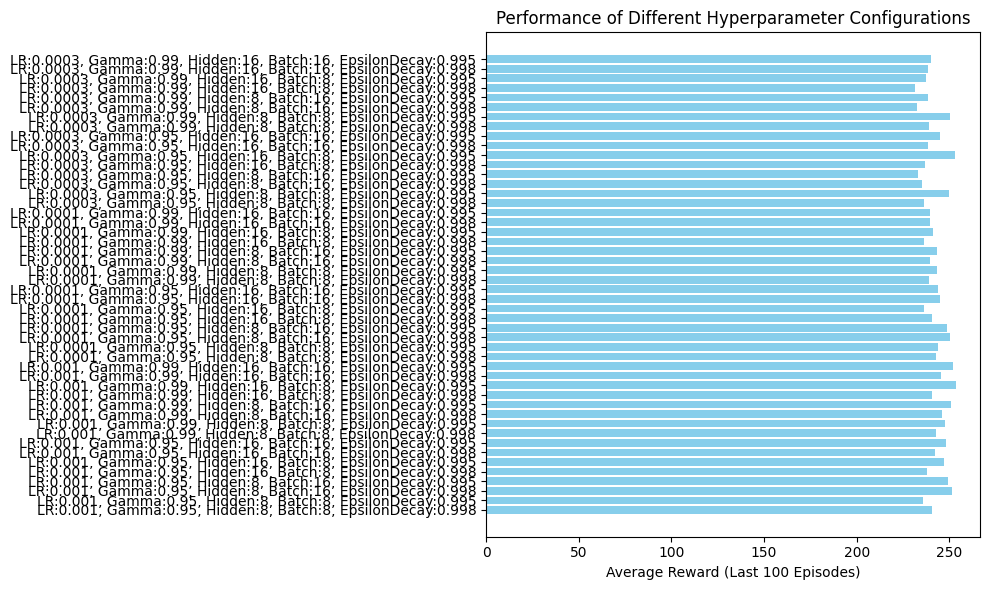



Best Configuration: LR=0.001, Gamma=0.99, Hidden=16, Batch=8, EpsilonDecay=0.995
Best Avg Reward (Last 100 episodes): 253.7892841476702


In [90]:
if __name__ == "__main__":
    run_grid_search()

# Training with GS Results

* Training

In [20]:
if __name__ == "__main__":
    # Initialize Environment
    grid_dim = 9  # Grid size
    max_steps = 500  # Max steps before episode ends
    lives = 3  # Number of lives agent has
    action_dim = 4  # UP, DOWN, LEFT, RIGHT
    feature_dim = 166
    env =TreasureHuntEnv(size=grid_dim, max_steps=max_steps, lives=lives)

    grad_clip=0.5
    epsilon_start=1.0
    epsilon_min=0.1
     # Tuned Parameters Best Values
    learning_rate=0.001
    gamma=0.99
    hidden_size=16
    batch_size=8
    epsilon_decay=0.995
    agent = PolicyGradientAgent(grid_dim=grid_dim,
                                feature_dim=feature_dim,
                                action_dim=action_dim,
                                learning_rate=learning_rate,
                                gamma=gamma,
                                hidden_size=hidden_size,
                                batch_size=batch_size,
                                grad_clip=grad_clip,
                                epsilon_start=epsilon_start,
                                epsilon_min=epsilon_min,
                                epsilon_decay=epsilon_decay
                               )
    
    num_episodes=4000
    log_every=2
    logs,reward_per_step_logs = agent.learn(env, 
                       num_episodes=num_episodes,
                       log_every=log_every,
                       size=grid_dim, 
                       max_steps=max_steps,
                       lives=lives
                                           )

Episode 0, Reward: -25, Loss: 0, Epsilon: 0.995
Episode 2, Reward: -22, Loss: 0, Epsilon: 0.985
Episode 4, Reward: -782, Loss: 0, Epsilon: 0.975
Episode 6, Reward: -61, Loss: 0, Epsilon: 0.966
Episode 8, Reward: -201, Loss: 2.235865592956543, Epsilon: 0.956
Episode 10, Reward: -1360, Loss: 2.235865592956543, Epsilon: 0.946
Episode 12, Reward: -181, Loss: 2.235865592956543, Epsilon: 0.937
Episode 14, Reward: -565, Loss: 2.235865592956543, Epsilon: 0.928
Episode 16, Reward: -834, Loss: 7.235228538513184, Epsilon: 0.918
Episode 18, Reward: -645, Loss: 7.235228538513184, Epsilon: 0.909
Episode 20, Reward: -365, Loss: 7.235228538513184, Epsilon: 0.900
Episode 22, Reward: -5, Loss: 7.235228538513184, Epsilon: 0.891
Episode 24, Reward: -1317, Loss: -3.4299681186676025, Epsilon: 0.882
Episode 26, Reward: 22, Loss: -3.4299681186676025, Epsilon: 0.873
Episode 28, Reward: -241, Loss: -3.4299681186676025, Epsilon: 0.865
Episode 30, Reward: -21, Loss: -3.4299681186676025, Epsilon: 0.856
Episode 32,

* Save Results

In [21]:
save_logs(logs,reward_per_step_logs,"grid_best_3")

Logs are save at ../Tensorboard logs/vpg_logs/vpg_training_logs_grid_best_3.csv , ../Tensorboard logs/vpg_logs/vpg_training_reward_per_step_logs_grid_best_3.csv


In [22]:
save_model(agent,"../Models/VPG/vpg_grid_best_3.pth",extra_logs={
        'logs': logs,
        'reward_per_step_logs': reward_per_step_logs
    })

Model and training state saved to ../Models/VPG/vpg_grid_best_3.pth


* Visualize Results:
  Loss - Cumulative Rewards - Episode Length

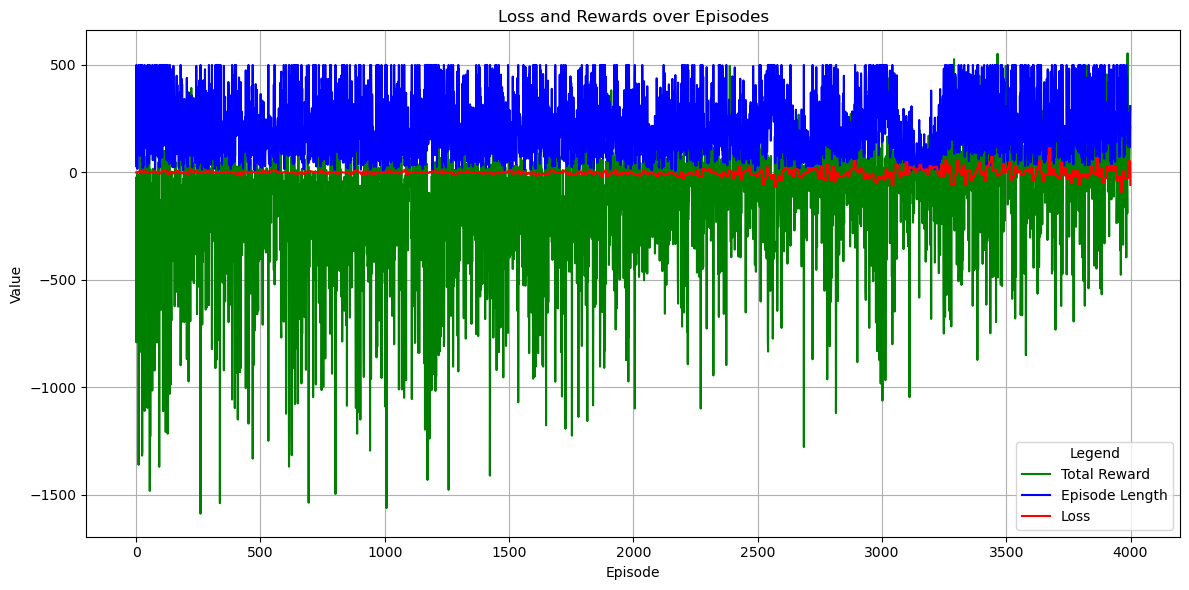

In [23]:
df_logs=load_logs("vpg_training_logs_grid_best_3")
plt.figure(figsize=(12, 6))

# Total Reward
plt.plot(df_logs.index, df_logs['total_reward'], label='Total Reward', color='green')

# Episode Length
plt.plot(df_logs.index, df_logs['episode_length'], label='Episode Length', color='blue')

# Loss
plt.plot(df_logs.index, df_logs['loss'], label='Loss', color='red')

plt.title("Loss and Rewards over Episodes")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend(title="Legend")
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

* Testing

In [30]:
test_env = TreasureHuntEnv(size=9, max_steps=200, lives=3,render_mode="human")
agent2 = PolicyGradientAgent(grid_dim=grid_dim,
                                feature_dim=feature_dim,
                                action_dim=action_dim,
                                learning_rate=learning_rate,
                                gamma=gamma,
                                hidden_size=hidden_size,
                                batch_size=batch_size,
                                grad_clip=grad_clip,
                                epsilon_start=epsilon_start,
                                epsilon_min=epsilon_min,
                                epsilon_decay=epsilon_decay
                               )
load_model(agent2, "../Models/VPG/vpg_grid_best_3.pth")

agent2.policy.eval()  # Set to eval mode for inference

obs = test_env.reset()[0]
grid, features = process_observation(obs, size=9, max_steps=200, lives=3)

done = False
total_reward = 0
while not done:
    action = agent2.select_action((grid, features))
    obs, reward, done, _, _ = test_env.step(action)
    grid, features = process_observation(obs, size=9, max_steps=200, lives=3)
    total_reward += reward
    test_env.render()
    time.sleep(0.3)
env.close()
print(f"Total reward from loaded agent: {total_reward}")

Model and training state loaded from ../Models/VPG/vpg_grid_best_3.pth
Total reward from loaded agent: 38
